In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
import anDiffReg as an

In [2]:
# exemplary data: mixture of FBMs
# this is the same system as considered in the "Non-parametric deconvolution" section of the article

ln = 100
n = 10**4
dt =  1
ts = dt*np.arange(1,ln+1)

msd = np.empty((ln-1,n), dtype = np.float64)
S = np.empty((ln,ln), dtype = np.float64)

for k in range(n):
    # (logD, alpha) distribution is 2 rectangles 
    if np.random.rand() < 1/2:
        alpha = np.random.uniform(0.4,0.6)
    else:
        alpha = np.random.uniform(0.8,1.0)
    logD = np.random.uniform(-1.0,1.0)

    for i in range(ln):
        for j in range(i,ln):
            S[i,j] = 10**logD * (ts[i]**alpha + ts[j]**alpha - np.abs(ts[j] - ts[i])**alpha)
            S[j,i] = S[i,j]
    A = cholesky(S, lower=False)
    xi = np.random.randn(len(ts))
    X = A.T @ xi

    msd[:,k] = np.ravel(an.tamsd(X))

In [3]:
# fitting

ols, covOLS = an.fit_ols(msd, 1, dt)
gls, covGLS = an.fit_gls(msd, 1, dt, ols[1,:]) 

e:\Kod\anDiffReg\anDiffReg.py:116: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  gR = np.linalg.inv(Ts.T @ iC[:, :, j0] @ Ts) @ Ts.T @ iC[:, :, j0]


In [ ]:
# getting kde
from scipy.stats import gaussian_kde

# this is for the gls estimate 
kde = gaussian_kde(gls, "silverman")

# for the OLS estimate switch to this line 
#kde = gaussian_kde(ols, "silverman")

alphas = np.linspace(0.2,1.3,512)
logDs = np.linspace(-1.5, 1.5, 512)
X, Y = np.mgrid[-1.5:1.5:512j, 0.2:1.3:512j]
pos = np.vstack([X.ravel(), Y.ravel()])
den = np.reshape(kde(pos).T, X.shape) # original density

(0.2, 1.3)

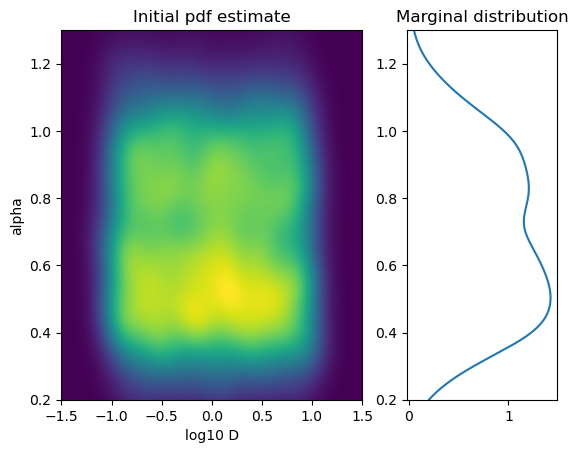

In [122]:
# plotting initial estimate

fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[2, 1])

ax1.imshow(np.rot90(den), aspect = "auto", extent = (-1.5,1.5,0.2,1.3))
ax1.set_title("Initial pdf estimate")
ax1.set_xlabel("log10 D")
ax1.set_ylabel("alpha")

denMarg0 = np.sum(den, axis=0)
denMarg0 *= 1/(sum(denMarg0)*(1.1/512))

ax2.plot(denMarg0, alphas)
ax2.set_title("Marginal distribution")
ax2.set_ylim(0.2,1.3)

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.signal import fftconvolve
from tqdm.auto import tqdm

def deconvolve_internal(logDs, alphas, den, C, nIter):
    """
    Performs Richardson-Lucy deconvolution with Gaussian kernel given covariance C.
    """
    res = np.copy(den)
    
    mean = [logDs[len(logDs) // 2], alphas[len(alphas) // 2]]
    mvn = multivariate_normal(mean=mean, cov=C)
    
    ns = np.array([[mvn.pdf([x, y]) for y in alphas] for x in logDs])
    ins = np.flip(ns)

    for _ in range(nIter):
        d = fftconvolve(res, ns, mode = "same")
        d[np.abs(d) < 1e-12] = 1e-12
        res *= fftconvolve(den / d, ins, mode = "same")

    return res

In [125]:

def deconvolve_gls(logDs, alphas, den, dt, ln, dim, alpha, method = "simple", nIter = 30):
    """
        deconvolve_gls(logDs, alphas, den, dt, ln, dim, alpha, method, nIter = 30)
        deconvolve_gls(logDs, alphas, den, dt, ln, dim, (alpha_min,alpha_max), method, nIter = 30)

    Deconvolving pdf of estimated (logD, α) obtained with the GLS method. It removes the blur caused by the estimation errors, reconstructing the original distribution of (logD, α). This method assumes the data was FBM.
    Input:
    - logDs: labels of log diffusivity
    - αlphas: labels of anomalous index
    - den: density which we want to deconvolve
    - dt: sampling inverval
    - ln: length of the orignal trajectory used
    - dim: trajectory dimension (typically 1, 2 or 3)
    - method: "simple" or "full"
    For simple deconvolution provide:
    - alpha: the anomalous index value for which deconvolve, should be the most representative of the sample
    For full deconvolution provide:
    - (alpha_min,alpha_max): range of α for which deconvolve
    Full deconvolution is much more computationally expensive, but the result better reflects the original distribution.

    Optional input:
    - nIter: number of steps in the Richardson-Lucy deconvolution algorithm

    Output: matrix with the deconvolved pdf. 
    """
    if method == "simple":
        return deconvolve_gls_simple(logDs, alphas, den, dt, ln, dim, alpha, nIter)
    elif method == "full":
        deconvolve_gls_full(logDs, alphas, den, dt, ln, dim, alpha, nIter)

def deconvolve_ols(logDs, alphas, den, dt, ln, dim, alpha, w, method = "simple", nIter = 30):
    """
        deconvolve_ols(logDs, alphas, den, dt, ln, dim, alpha, w, method, nIter = 30)
        deconvolve_ols(logDs, alphas, den, dt, ln, dim, alpha, w, method, nIter = 30)
    Deconvolving pdf of estimated (logD, α) obtained with the OLS method. It removes the blur caused by the estimation errors, reconstructing the original distribution of (logD, α). This method assumes the data was FBM.
    Input:
    - logDs: labels of log diffusivity
    - alphas: labels of anomalous index
    - den: density which we want to deconvolve
    - dt: sampling inverval
    - ln: length of the orignal trajectory used
    - dim: trajectory dimension (typically 1, 2 or 3)
    - w: size of window in which the OLS was calculated 
    - method: "simple" or "full"
    For simple deconvolution provide:
    - alpha: the value for which deconvolve, should be the most typical in the sample
    For full deconvolution provide:
    - (alpha_min,alpha_max): range of α for which deconvolve
    Full deconvolution is much more computationally expensive, but the result better reflects the original distribution.

    Optional input:
    - nIter: number of steps in the Richardson-Lucy deconvolution algorithm

    Output: matrix with the deconvolved pdf. 
    """
    if method == "simple":
        return deconvolve_gls_simple(logDs, alphas, den, dt, ln, dim, alpha, w, nIter)
    elif method == "full":
        deconvolve_gls_full(logDs, alphas, den, dt, ln, dim, alpha, w, nIter)

def deconvolve_gls_simple(logDs, alphas, den, dt, ln, dim, alpha, nIter):
    ts = dt * np.arange(1,ln+1) 
    Ts = np.c_[np.ones(ln-1), np.log10(ts[:-1])]
    _, Sigma = an.errCov(ts, dim, alpha)

    return deconvolve_internal(logDs, alphas, den, np.linalg.inv(Ts.T @ np.linalg.inv(Sigma) @ Ts), nIter)

def deconvolve_ols_simple(logDs, alphas, den, dt, ln, dim, alpha, w, nIter):
    ts = dt * np.arange(1,ln+1) 
    Ts = np.c_[np.ones(w), np.log10(ts[:w])]
    _, Sigma = an.errCov(ts, dim, alpha, w)
    S = np.linalg.inv(Ts.T @ Ts) @ Ts.T
    return deconvolve_internal(logDs, alphas, den, S @ Sigma @ S.T, nIter)

def deconvolve_gls_full(logDs, alphas, den, dt, ln, dim, alpha_range, nIter = 30):
    alpha_min,alpha_max = alpha_range
    ts = dt * np.arange(1,ln+1) 
    Ts = np.c_[np.ones(ln-1), np.log10(ts[:-1])]
    _, Sigma = an.errCov(ts, dim, alpha_min)

    res = deconvolve_internal(logDs, alphas, den, np.linalg.inv(Ts.T @ np.linalg.inv(Sigma) @ Ts), nIter)

    j1 = np.argmax(alphas >= alpha_min)
    j2 = np.argwhere(alphas <= alpha_max).max()

    for k in tqdm(range(j1,j2)):
        _, Sigma = an.errCov(ts, 1, alphas[k])
        zs = deconvolve_internal(logDs, alphas, den, np.linalg.inv(Ts.T @ np.linalg.inv(Sigma) @ Ts), nIter)
        res[:,k] = zs[:,k]

    _, Sigma = an.errCov(ts, 1, alpha_max )
    zs = deconvolve_internal(logDs, alphas, den, np.linalg.inv(Ts.T @ np.linalg.inv(Sigma) @ Ts), nIter)

    res[:,j2:] = zs[:,j2:]

    res /= (np.sum(res)*(alphas[1]-alphas[0])*(logDs[1]-logDs[0])) # normalise
    return res

def deconvolve_ols_full(logDs, alphas, den, dt, ln, dim, alpha_range, w, nIter):
    alpha_min,alpha_max = alpha_range
    ts = dt * np.arange(1,ln+1) 
    Ts = np.c_[np.ones(w), np.log10(ts[:w])]
    _, Sigma = an.errCov(ts, dim, alpha_min, w)
    S = np.linalg.inv(Ts.T @ Ts) @ Ts.T

    res = deconvolve_internal(logDs, alphas, den, S @ Sigma @ S.T, nIter)

    j1 = np.argmax(alphas >= alpha_min)
    j2 = np.argwhere(alphas <= alpha_max).max()

    for k in tqdm(range(j1,j2)):
        _, Sigma = an.errCov(ts, 1, alphas[k], w)
        zs = deconvolve_internal(logDs, alphas, den, S @ Sigma @ S.T, nIter)
        res[:,k] = zs[:,k]

    _, Sigma = an.errCov(ts, 1, alpha_max, w)
    zs = deconvolve_internal(logDs, alphas, den, S @ Sigma @ S.T, nIter)

    res[:,j2:] = zs[:,j2:]

    res /= (np.sum(res)*(alphas[1]-alphas[0])*(logDs[1]-logDs[0])) # normalise
    return res

In [126]:
# simple deconvolution

dim = 1
alpha = 0.7 # α for which to deconvolve

# calculation
deconvolvedPDF1 = deconvolve_gls(logDs, alphas, den, dt, ln, dim, alpha, "simple")

# for the OLS switch to this lines
#w = 10 # OLS window size
#deconvolvedPDF1 = deconvolve_ols_simple(logDs, alphas, den, dt, ln, dim, alpha, w, "simple")

(0.2, 1.3)

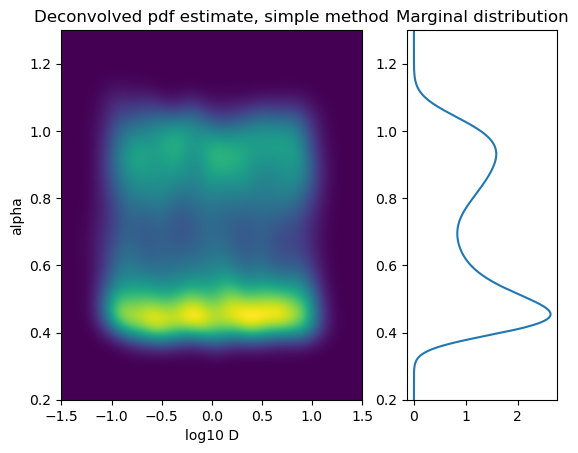

In [127]:
# plot

fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[2, 1])

ax1.imshow(np.rot90(deconvolvedPDF1), aspect = "auto", extent = (-1.5,1.5,0.2,1.3))
ax1.set_title("Deconvolved pdf estimate, simple method")
ax1.set_xlabel("log10 D")
ax1.set_ylabel("alpha")

denMarg1 = np.sum(deconvolvedPDF1, axis=0)
denMarg1 *= 1/(sum(denMarg1)*(1.1/512))

ax2.plot(denMarg1, alphas)
ax2.set_title("Marginal distribution")
ax2.set_ylim(0.2, 1.3)

In [ ]:
# full deconvolution 

dim = 1
alpha_min, alpha_max = 0.3, 1.1 # range of α for which to deconvolve

# calculation, note it can take significantly longer time
deconvolvedPDF2 = deconvolve_gls(logDs, alphas, den, dt, ln, dim, (alpha_min,alpha_max), "full")

# for the OLS switch to this lines
# w = 10 # OLS window size
# deconvolvedPDF2 = deconvolve_ols_full(logDs, alphas, den, dt, ln, dim, (alpha_min,alpha_max), w, "full")

(0.2, 1.3)

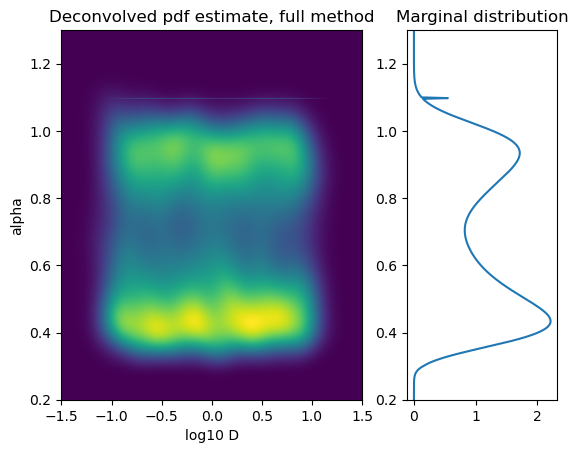

In [121]:
# plot

fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[2, 1])

ax1.imshow(np.rot90(deconvolvedPDF2), aspect = "auto", extent = (-1.5,1.5,0.2,1.3))
ax1.set_title("Deconvolved pdf estimate, full method")
ax1.set_xlabel("log10 D")
ax1.set_ylabel("alpha")

denMarg2 = np.sum(deconvolvedPDF2, axis=0)
denMarg2 *= 1/(sum(denMarg2)*(1.1/512))

ax2.plot(denMarg2, alphas)
ax2.set_title("Marginal distribution")
ax2.set_ylim(0.2, 1.3)

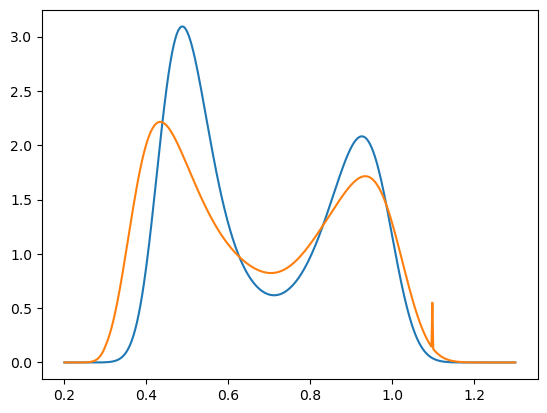

In [124]:
denMarg2 = np.sum(deconvolvedPDF2, axis=0)
denMarg2 *= 1/(sum(denMarg2)*(1.1/512))
denMarg1 = np.sum(deconvolvedPDF1, axis=0)
denMarg1 *= 1/(sum(denMarg1)*(1.1/512))
plt.plot(alphas, denMarg1)
plt.plot(alphas,denMarg2)